In [35]:
# Customer Clustering Analysis: Tenure and Monthly Charges
# Technical Implementation for Customer Segmentation

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import warnings
warnings.filterwarnings('ignore')

# Load the data
df = pd.read_csv('data/processed/Dataset_ATS_v2_processed.csv', index_col=0)

# Focus on tenure and monthly charges as specified
clustering_data = df[['tenure', 'MonthlyCharges']].copy()
print(f"{len(clustering_data)} customers loaded")
print("Features:", clustering_data.columns.tolist())

clustering_data.describe()

7043 customers loaded
Features: ['tenure', 'MonthlyCharges']


,tenure,MonthlyCharges
count,7043.000000,7043.000000
mean,0.449599,0.462958
std,0.341104,0.297937
min,0.000000,0.000000
25%,0.125000,0.178218
50%,0.402778,0.514851
75%,0.763889,0.712871
max,1.000000,1.000000


In [36]:
# Standardize features for clustering
scaler = StandardScaler()
X_scaled = scaler.fit_transform(clustering_data)

# Find optimal number of clusters
k_range = range(2, 9)
sse_values = []
silhouette_scores = []

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    sse_values.append(kmeans.inertia_)
    sil_score = silhouette_score(X_scaled, kmeans.labels_)
    silhouette_scores.append(sil_score)
    print(f"K={k}: SSE={kmeans.inertia_:.0f}, Silhouette={sil_score:.3f}")

K=2: SSE=7841, Silhouette=0.411
K=3: SSE=4622, Silhouette=0.446
K=4: SSE=2846, Silhouette=0.476
K=5: SSE=2339, Silhouette=0.430
K=6: SSE=1929, Silhouette=0.415
K=7: SSE=1556, Silhouette=0.434
K=8: SSE=1345, Silhouette=0.434


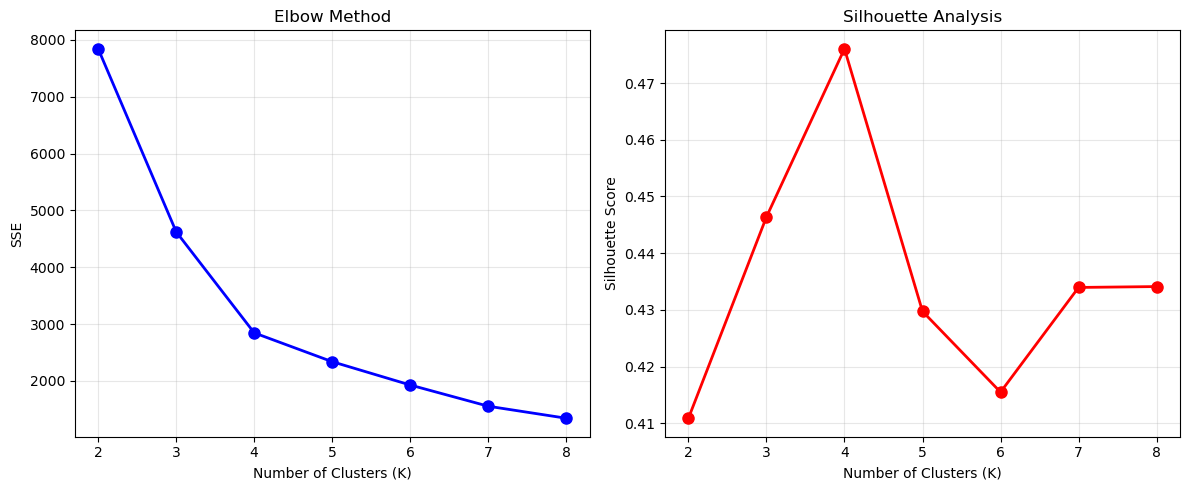

In [37]:
# Plot elbow curve
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.plot(k_range, sse_values, 'bo-', linewidth=2, markersize=8)
ax1.set_xlabel('Number of Clusters (K)')
ax1.set_ylabel('SSE')
ax1.set_title('Elbow Method')
ax1.grid(True, alpha=0.3)

ax2.plot(k_range, silhouette_scores, 'ro-', linewidth=2, markersize=8)
ax2.set_xlabel('Number of Clusters (K)')
ax2.set_ylabel('Silhouette Score')
ax2.set_title('Silhouette Analysis')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [38]:
# Based on elbow method, using K=4
optimal_k = 4

# Train final model
final_kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
cluster_labels = final_kmeans.fit_predict(X_scaled)

# Check clustering quality
sil_score = silhouette_score(X_scaled, cluster_labels)
print(f"K={optimal_k}, silhouette = {sil_score:.3f}")

# Add clusters to dataframe
df_clustered = df.copy()
df_clustered['Cluster'] = cluster_labels

# Analyze clusters
cluster_summary = df_clustered.groupby('Cluster').agg({
    'tenure': ['count', 'mean', 'std'],
    'MonthlyCharges': ['mean', 'std'],
    'Churn': 'mean'
}).round(3)

cluster_summary.columns = ['Count', 'Avg_Tenure', 'Std_Tenure', 'Avg_Charges', 'Std_Charges', 'Churn_Rate']
cluster_summary

K=4, silhouette = 0.476


,Count,Avg_Tenure,Std_Tenure,Avg_Charges,Std_Charges,Churn_Rate
Cluster,,,,,,
0,2202,0.206,0.154,0.626,0.122,0.492
1,1733,0.146,0.128,0.143,0.136,0.245
2,1948,0.816,0.155,0.743,0.139,0.157
3,1160,0.751,0.170,0.160,0.155,0.048


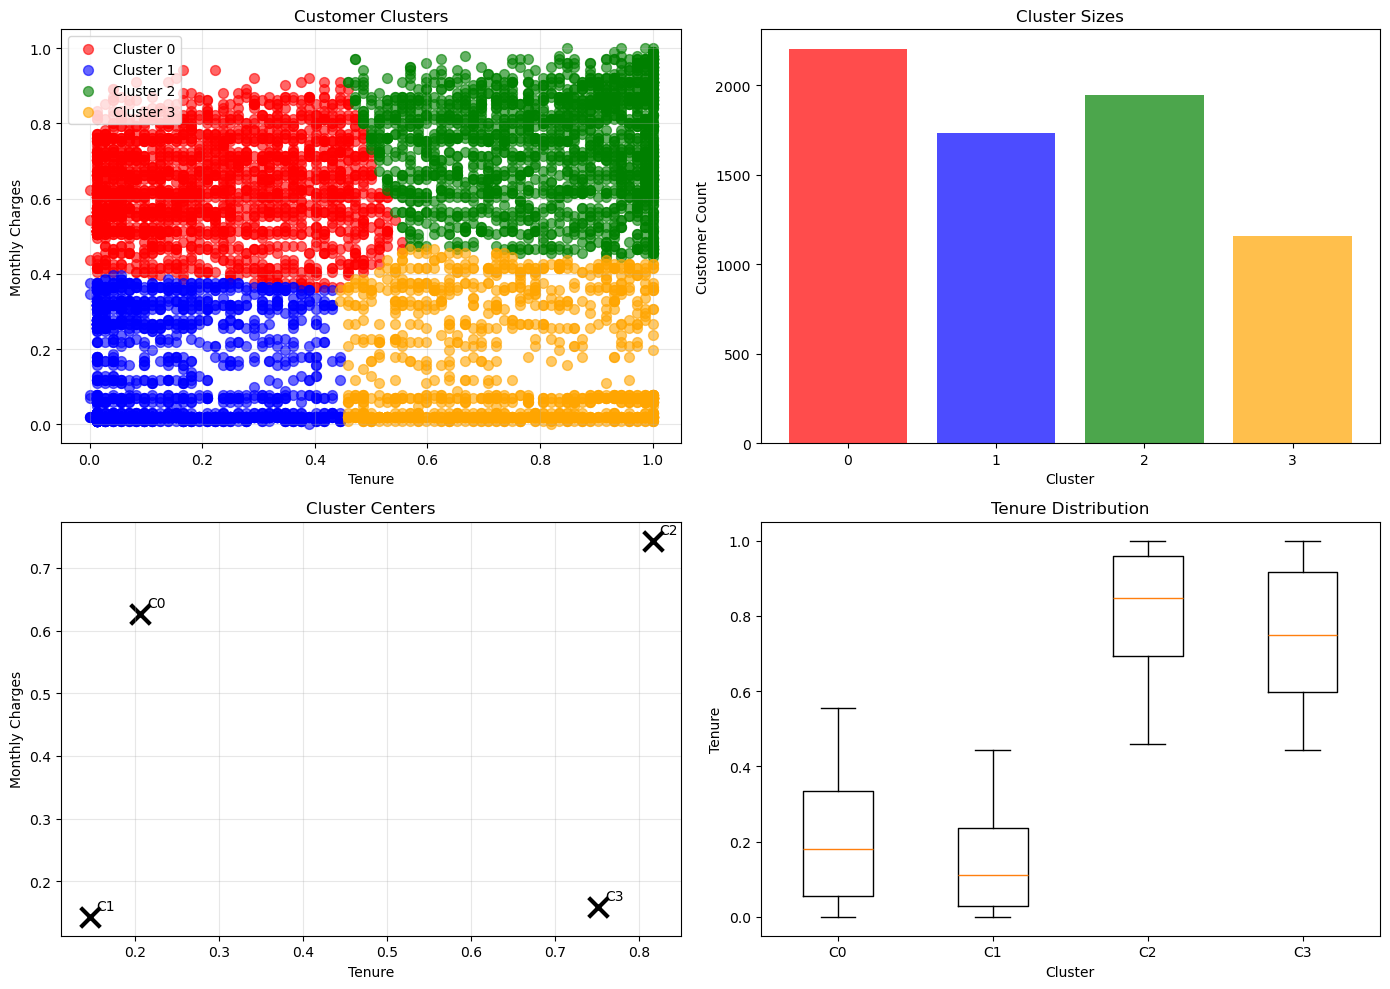

In [39]:
# Visualize the clusters
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(14, 10))

# Main scatter plot
colors = ['red', 'blue', 'green', 'orange']
for i in range(optimal_k):
    cluster_data = df_clustered[df_clustered['Cluster'] == i]
    ax1.scatter(cluster_data['tenure'], cluster_data['MonthlyCharges'], 
               c=colors[i], label=f'Cluster {i}', alpha=0.6, s=50)

ax1.set_xlabel('Tenure')
ax1.set_ylabel('Monthly Charges')
ax1.set_title('Customer Clusters')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Cluster sizes
cluster_counts = df_clustered['Cluster'].value_counts().sort_index()
ax2.bar(range(optimal_k), cluster_counts.values, color=colors, alpha=0.7)
ax2.set_xlabel('Cluster')
ax2.set_ylabel('Customer Count')
ax2.set_title('Cluster Sizes')
ax2.set_xticks(range(optimal_k))

# Cluster centers
cluster_centers = scaler.inverse_transform(final_kmeans.cluster_centers_)
ax3.scatter(cluster_centers[:, 0], cluster_centers[:, 1], 
           c='black', marker='x', s=200, linewidth=3)
for i, center in enumerate(cluster_centers):
    ax3.annotate(f'C{i}', (center[0], center[1]), 
                xytext=(5, 5), textcoords='offset points')
ax3.set_xlabel('Tenure')
ax3.set_ylabel('Monthly Charges')
ax3.set_title('Cluster Centers')
ax3.grid(True, alpha=0.3)

# Tenure distribution by cluster
tenure_by_cluster = [df_clustered[df_clustered['Cluster']==i]['tenure'].values for i in range(optimal_k)]
ax4.boxplot(tenure_by_cluster, labels=[f'C{i}' for i in range(optimal_k)])
ax4.set_xlabel('Cluster')
ax4.set_ylabel('Tenure')
ax4.set_title('Tenure Distribution')

plt.tight_layout()
plt.show()

In [40]:
# Print cluster characteristics
for i in range(optimal_k):
    cluster_data = df_clustered[df_clustered['Cluster'] == i]
    print(f"Cluster {i}: {len(cluster_data)} customers")
    print(f"  tenure: {cluster_data['tenure'].mean():.3f}")
    print(f"  charges: {cluster_data['MonthlyCharges'].mean():.3f}")
    print(f"  churn: {cluster_data['Churn'].mean():.3f}")

# Save results
df_clustered.to_csv('data/processed/customers_clustered.csv', index=False)
centers_df = pd.DataFrame(cluster_centers, columns=['tenure', 'MonthlyCharges'])
centers_df.to_csv('data/processed/cluster_centers.csv')

print(f"Clustering results: {optimal_k} clusters, score = {sil_score:.3f}")

Cluster 0: 2202 customers
  tenure: 0.206
  charges: 0.626
  churn: 0.492
Cluster 1: 1733 customers
  tenure: 0.146
  charges: 0.143
  churn: 0.245
Cluster 2: 1948 customers
  tenure: 0.816
  charges: 0.743
  churn: 0.157
Cluster 3: 1160 customers
  tenure: 0.751
  charges: 0.160
  churn: 0.048
Clustering results: 4 clusters, score = 0.476
